In [ ]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from itertools import product
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from utils import *
from modeling_utils import visualize_learned_embeddings

In [2]:
cards = torch.tensor(list(range(52)))
ranks = torch.tensor([get_rank_idx(idx) for idx in cards])
suits = torch.tensor([get_suit_idx(idx) for idx in cards])

In [3]:
class CardEmbeddingModel(nn.Module):
    def __init__(self, embedding_dim=2):
        super().__init__()
        self.embedder = nn.Embedding(52, embedding_dim)
        self.suit_classifier = nn.Linear(embedding_dim, 4)
        self.rank_classifier = nn.Linear(embedding_dim, 13)
        
    def forward(self, x):
        x_embed = self.embedder(x)
        suit_logits = self.suit_classifier(x_embed)
        rank_logits = self.rank_classifier(x_embed)
        return rank_logits, suit_logits, x_embed

In [4]:
def loss_function(rank_logit, suit_logit, ranks, suits):
    rank_loss = F.cross_entropy(rank_logit, ranks)
    suit_loss = F.cross_entropy(suit_logit, suits)
    total_loss = rank_loss + suit_loss
    return rank_loss, suit_loss, total_loss

In [5]:
def train_model(model, optimizer, epochs):
    rank_losses = []
    suit_losses = []
    losses = []
    for epoch in range(1,epochs+1):
        rank_logit, suit_logit, _ = model(cards)
        rank_loss, suit_loss, tot_loss = loss_function(rank_logit, suit_logit, ranks, suits)

        tot_loss = rank_loss + suit_loss
        losses.append(tot_loss.item())
        rank_losses.append(rank_loss.item())
        suit_losses.append(suit_loss.item())
        tot_loss.backward()
        optimizer.step()
        if (epoch % (epochs//5)) == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {tot_loss.item():.4f}")
    return rank_losses, suit_losses, losses

In [6]:
model = CardEmbeddingModel(embedding_dim=32)
optimizer = torch.optim.SGD(params=model.parameters(), lr=.001)


In [7]:
epochs = 500
rank_losses, suit_losses, losses = train_model(model, optimizer, epochs=epochs)

Epoch [100/500], Loss: 1.5800
Epoch [200/500], Loss: 0.2711
Epoch [300/500], Loss: 0.0092
Epoch [400/500], Loss: 0.0005
Epoch [500/500], Loss: 0.0000


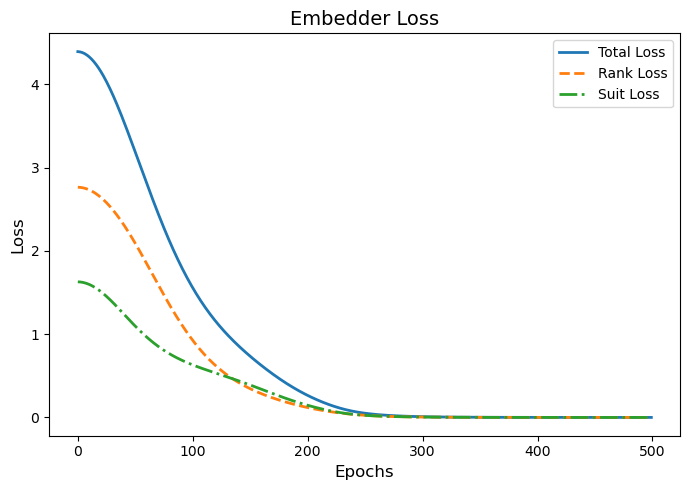

In [8]:
plt.figure(figsize=(7, 5))
sns.lineplot(x=list(range(epochs)), y=losses, label="Total Loss", linestyle='-', linewidth=2)
sns.lineplot(x=list(range(epochs)), y=rank_losses, label="Rank Loss", linestyle='--', linewidth=2)
sns.lineplot(x=list(range(epochs)), y=suit_losses, label="Suit Loss", linestyle='-.', linewidth=2)

plt.title("Embedder Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)

plt.legend(fontsize=10) 
plt.tight_layout()
plt.show()

In [9]:
def compute_accuracy(model, card_indices, ranks, suits):
    with torch.no_grad():
        rank_logits, suit_logits, _ = model(card_indices)
        rank_preds = torch.argmax(rank_logits, dim=1) 
        suit_preds = torch.argmax(suit_logits, dim=1)

        rank_acc = (rank_preds == ranks).float().mean().item()
        suit_acc = (suit_preds == suits).float().mean().item()
    return rank_acc, suit_acc

In [10]:
rank_acc, suit_acc = compute_accuracy(model, cards, ranks, suits)
print('Rank Accuracy: ', rank_acc)
print('Suit Accuracy: ', suit_acc)

Rank Accuracy:  1.0
Suit Accuracy:  1.0


Epoch [1000/5000], Loss: 1.4717
Epoch [2000/5000], Loss: 1.2310
Epoch [3000/5000], Loss: 1.0447
Epoch [4000/5000], Loss: 0.6278
Epoch [5000/5000], Loss: 0.5058


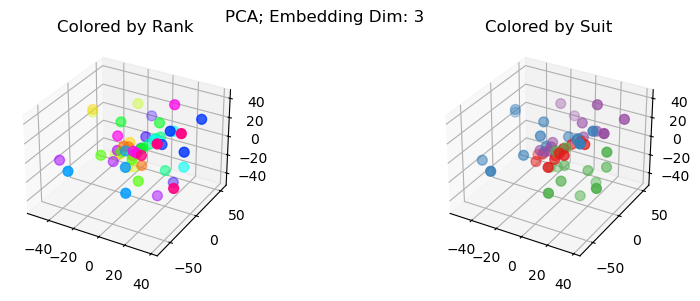

Epoch [1000/5000], Loss: 0.5801
Epoch [2000/5000], Loss: 0.0234
Epoch [3000/5000], Loss: 0.0008
Epoch [4000/5000], Loss: 0.0003
Epoch [5000/5000], Loss: 0.0005


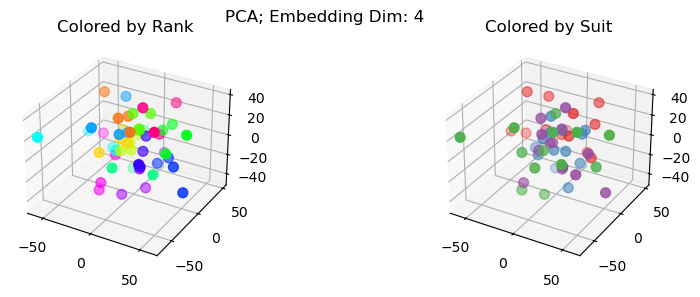

Epoch [400/2000], Loss: 0.8074
Epoch [800/2000], Loss: 0.0141
Epoch [1200/2000], Loss: 0.0006
Epoch [1600/2000], Loss: 0.0011
Epoch [2000/2000], Loss: 0.0003


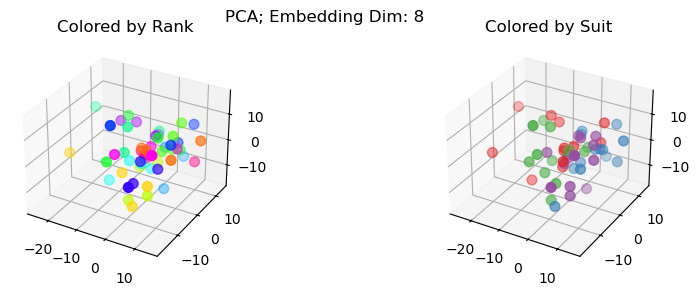

Epoch [400/2000], Loss: 0.4388
Epoch [800/2000], Loss: 0.0068
Epoch [1200/2000], Loss: 0.0021
Epoch [1600/2000], Loss: 0.0003
Epoch [2000/2000], Loss: 0.0001


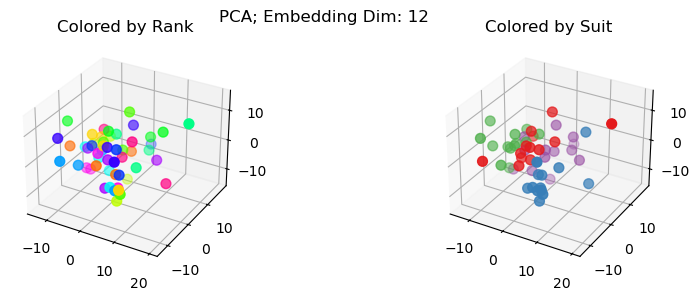

Epoch [200/1000], Loss: 1.5102
Epoch [400/1000], Loss: 0.0324
Epoch [600/1000], Loss: 0.0013
Epoch [800/1000], Loss: 0.0016
Epoch [1000/1000], Loss: 0.0008


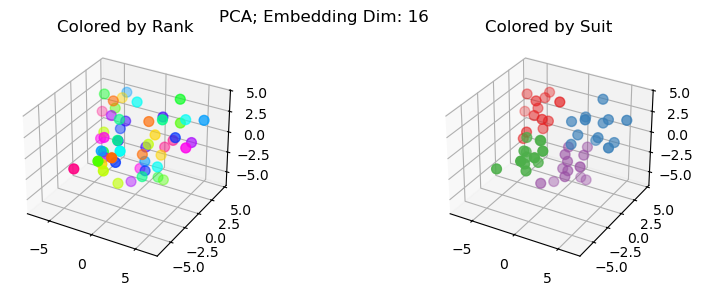

Epoch [100/500], Loss: 1.5738
Epoch [200/500], Loss: 0.3040
Epoch [300/500], Loss: 0.0236
Epoch [400/500], Loss: 0.0016
Epoch [500/500], Loss: 0.0002


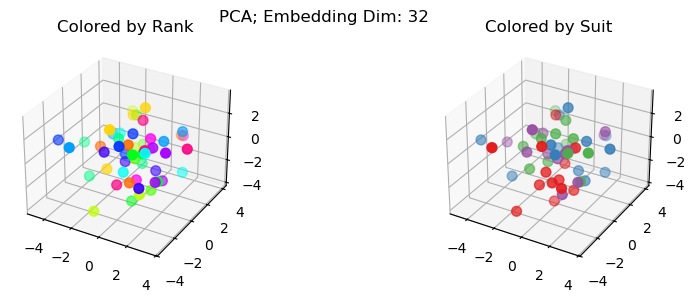

Epoch [100/500], Loss: 0.3948
Epoch [200/500], Loss: 0.0121
Epoch [300/500], Loss: 0.0002
Epoch [400/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0000


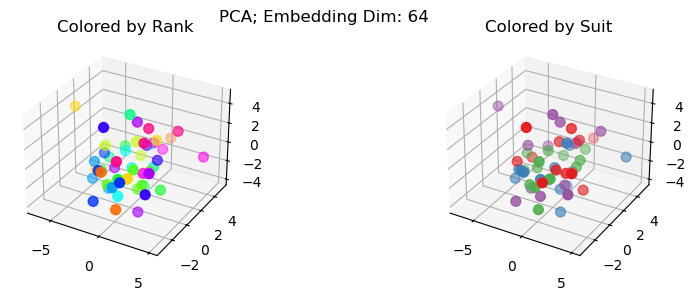

Epoch [100/500], Loss: 0.0246
Epoch [200/500], Loss: 0.0001
Epoch [300/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0000


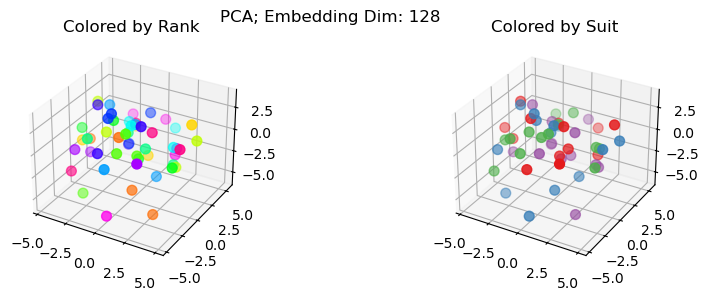

In [ ]:
embedding_dims = [3, 4, 8, 12, 16, 32, 64]
epochs = [5000, 5000, 2000, 2000, 1000, 500, 500]
for embedding_dim, epoch in zip(embedding_dims, epochs):
    model = CardEmbeddingModel(embedding_dim=embedding_dim)
    optimizer = torch.optim.SGD(params=model.parameters(), lr=.001)
    rank_losses, suit_losses, losses = train_model(model, optimizer, epochs=epoch)
    visualize_learned_embeddings(model, 'pca', 3, figsize=(10,3))

In [14]:
model = CardEmbeddingModel(embedding_dim=16)
optimizer = torch.optim.SGD(params=model.parameters(), lr=.001)
rank_losses, suit_losses, losses = train_model(model, optimizer, epochs=1000)

Epoch [200/1000], Loss: 1.4975
Epoch [400/1000], Loss: 0.0388
Epoch [600/1000], Loss: 0.0141
Epoch [800/1000], Loss: 0.0020
Epoch [1000/1000], Loss: 0.0012


In [21]:
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
with torch.no_grad(): 
    card_embeddings = model.embedder.weight.detach().numpy()
    card_similarity = cosine_similarity(card_embeddings)

In [32]:
similarity_df = pd.DataFrame(card_similarity, 
             columns=[idx_to_card(card) for card in cards], 
             index=[idx_to_card(card) for card in cards])

In [39]:
similarity_df.loc['Jd'].sort_values(ascending=False).head(15)

Jd    1.000000
Js    0.522961
6d    0.402682
Jh    0.398432
8s    0.394963
Td    0.368874
Qd    0.322409
3d    0.312924
6s    0.287172
2d    0.284361
7d    0.263783
8d    0.230228
Kd    0.217036
Ts    0.202691
4d    0.181314
Name: Jd, dtype: float32

In [86]:
from created_data import FlopDataset
from torch.utils.data import DataLoader

In [105]:
data = FlopDataset()
dataloader = DataLoader(data, batch_size=64, shuffle=True)
data.label_dict.keys()

dict_keys(['suitedness', 'pairness', 'connectedness', 'high_low_texture', 'high_card'])

In [106]:
class CardEmbedder(nn.Module):
    def __init__(self, embedding_dim=16):
        super().__init__()
        self.embedder = nn.Embedding(52, embedding_dim)
    def forward(self, x):
        return self.embedder(x)
    

In [107]:
class FlopClassifier(nn.Module):
    def __init__(self, embedding_dim=16, flop_representation='flatten'):
        super().__init__()
        self.flop_rep = flop_representation
        input_dim = embedding_dim if flop_representation == 'mean' else embedding_dim*3
        
        self.embedder = CardEmbedder(embedding_dim)
        self.classifiers = nn.ModuleDict({
            "suitedness": nn.Linear(input_dim, 3),
            "pairness": nn.Linear(input_dim, 4),
            "connectedness": nn.Linear(input_dim, 3),
            "high_low_texture": nn.Linear(input_dim, 4),
            "high_card": nn.Linear(input_dim, 13),
        })
    
    def forward(self, x):
        flop_embed = self.embedder(x)
        if self.flop_rep == 'flatten':
            flop_embed = torch.flatten(flop_embed, start_dim=1)
        elif self.flop_rep == 'mean':
            flop_embed = torch.mean(flop_embed, dim=1)
            
        return {name: classifier(flop_embed) for name, classifier in self.classifiers.items()}
        
        

In [123]:
def loss_function(output_logits, label_batch, class_weights={}):
    loss = 0
    for lab_name, lab_info in data.label_dict.items():
        logit = output_logits[lab_name]
        label = label_batch[:, lab_info['idx']]
        weight = class_weights.get(lab_name, None)
        loss += F.cross_entropy(logit, label, weight=weight)
    return loss

In [114]:
def compute_accuracy(output_logits, label_batch, label_dict):
    accuracies = {}
    for lab_name, lab_info in label_dict.items():
        predictions = torch.argmax(output_logits[lab_name], dim=1)
        true_labels = label_batch[:, lab_info['idx']]
        correct = (predictions == true_labels).sum().item()
        total = true_labels.size(0)
        accuracies[lab_name] = correct / total
    return accuracies


In [124]:
model = FlopClassifier(flop_representation='flatten')
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [135]:
def train_flopclassifier(model, optimizer, dataloader, class_weights={}, epochs=100):
    losses = []
    for epoch in range(1,epochs+1):
        tot_loss = 0
        tot_correct = {task: 0 for task in data.label_dict}
        total_samples = 0
        for batch_flop, batch_labels in dataloader:
            optimizer.zero_grad()
            output_logits = model(batch_flop)
        
            loss = loss_function(output_logits, batch_labels, class_weights=class_weights)
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
            accuracies = compute_accuracy(output_logits, batch_labels, data.label_dict)
            for task in tot_correct:
                tot_correct[task] += accuracies[task] * batch_labels.size(0)
            total_samples += batch_labels.size(0)
        
        avg_loss = tot_loss / len(dataloader)
        losses.append(avg_loss)
        avg_accuracies = {task: tot_correct[task] / total_samples for task in tot_correct}

        if (epoch % (epochs // 5)) == 0:
            accuracy_str = ", ".join([f"{task}: {acc:.2f}" for task, acc in avg_accuracies.items()])
            print(f"Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}, Accuracies - {accuracy_str}")

In [136]:
train_flopclassifier(model, optimizer, dataloader)

Epoch [20/100], Loss: 1.6167, Accuracies - suitedness: 0.55, pairness: 0.94, connectedness: 0.68, high_low_texture: 1.00, high_card: 1.00
Epoch [40/100], Loss: 1.6160, Accuracies - suitedness: 0.55, pairness: 0.94, connectedness: 0.68, high_low_texture: 1.00, high_card: 1.00
Epoch [60/100], Loss: 1.6156, Accuracies - suitedness: 0.55, pairness: 0.94, connectedness: 0.68, high_low_texture: 1.00, high_card: 1.00
Epoch [80/100], Loss: 1.6150, Accuracies - suitedness: 0.55, pairness: 0.94, connectedness: 0.69, high_low_texture: 1.00, high_card: 1.00
Epoch [100/100], Loss: 1.6150, Accuracies - suitedness: 0.55, pairness: 0.94, connectedness: 0.69, high_low_texture: 1.00, high_card: 1.00


In [126]:
from sklearn.metrics import confusion_matrix

In [165]:
def plot_confusion_matrix(model, dataloader, attribute):
    true_labels = []
    pred_labels = []
    model.eval()
    with torch.no_grad():
        for batch_flop, batch_labels in dataloader:
            output_logits = model(batch_flop)
            preds = torch.argmax(output_logits[attribute], dim=1).tolist()
            true_labels.extend(batch_labels[:, data.label_dict[attribute]['idx']].tolist())
            pred_labels.extend(preds)
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel(f"Predicted ({attribute})")
    plt.ylabel("True")
    plt.show()


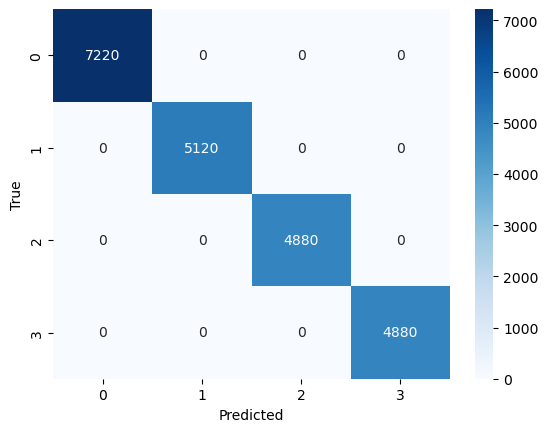

In [ ]:
plot_confusion_matrix(model, dataloader, 'high_low_texture')
plot_confusion_matrix(model, dataloader, 'high_card')
plot_confusion_matrix(model, dataloader, 'connectedness')
plot_confusion_matrix(model, dataloader, 'pairness')
plot_confusion_matrix(model, dataloader, 'suitedness')

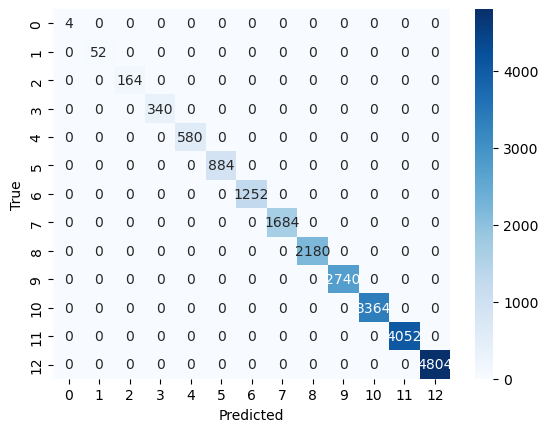

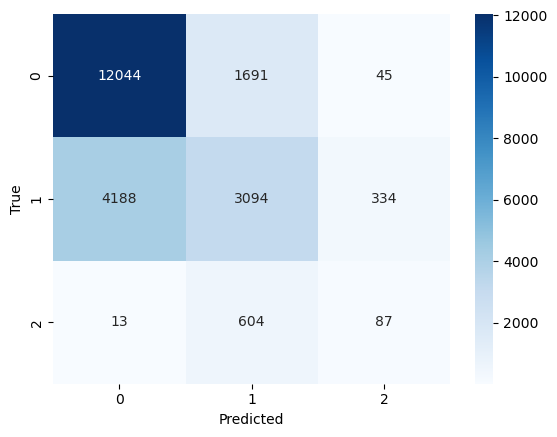

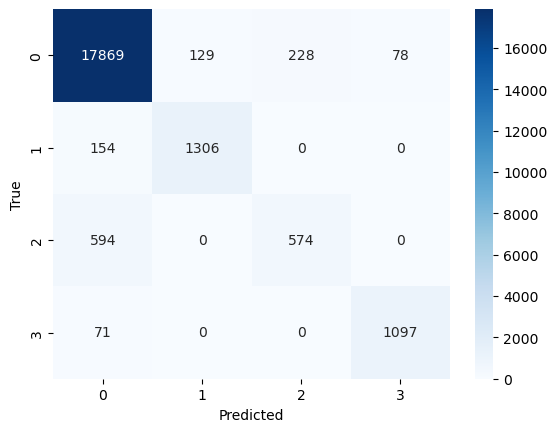

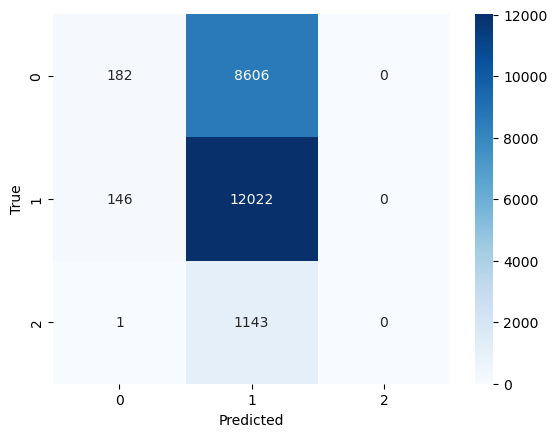

In [172]:
class_weights = {}
for attribute, attr_info in data.label_dict.items():
    vals = np.unique(data.labels[:,attr_info['idx']], return_counts=True)
    weights = 1.0 / torch.tensor(vals[1], dtype=torch.float)
    weights /= weights.sum()
    class_weights[attribute] = weights
    

In [171]:
model = FlopClassifier(flop_representation='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [173]:
train_flopclassifier(model, optimizer, dataloader, class_weights=class_weights)

Epoch [20/100], Loss: 2.7168, Accuracies - suitedness: 0.46, pairness: 0.40, connectedness: 0.39, high_low_texture: 1.00, high_card: 1.00
Epoch [40/100], Loss: 2.6599, Accuracies - suitedness: 0.43, pairness: 0.40, connectedness: 0.40, high_low_texture: 1.00, high_card: 1.00
Epoch [60/100], Loss: 2.6479, Accuracies - suitedness: 0.42, pairness: 0.40, connectedness: 0.38, high_low_texture: 1.00, high_card: 1.00
Epoch [80/100], Loss: 2.6495, Accuracies - suitedness: 0.45, pairness: 0.40, connectedness: 0.38, high_low_texture: 1.00, high_card: 1.00
Epoch [100/100], Loss: 2.6446, Accuracies - suitedness: 0.46, pairness: 0.40, connectedness: 0.40, high_low_texture: 1.00, high_card: 1.00


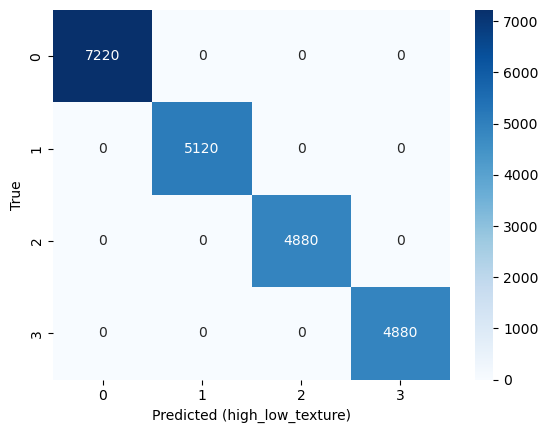

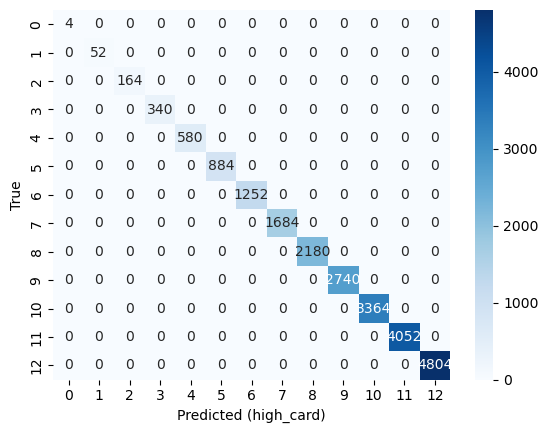

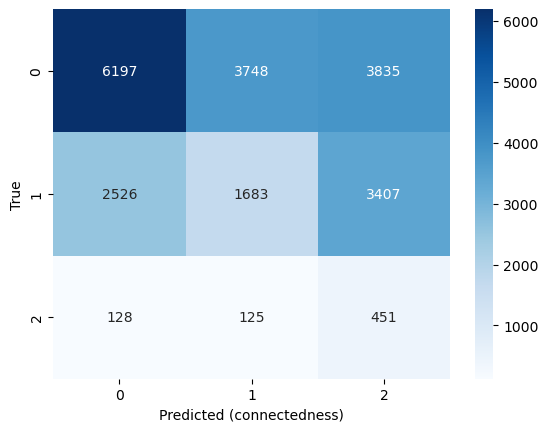

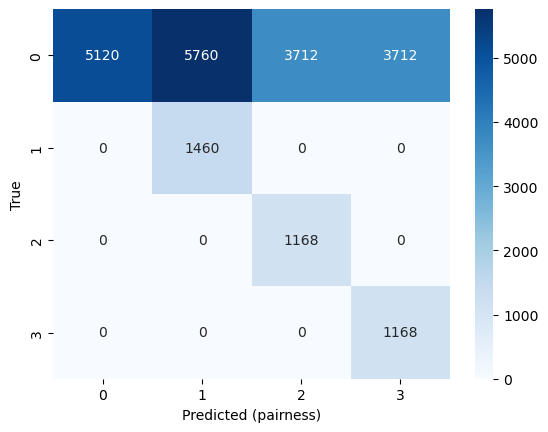

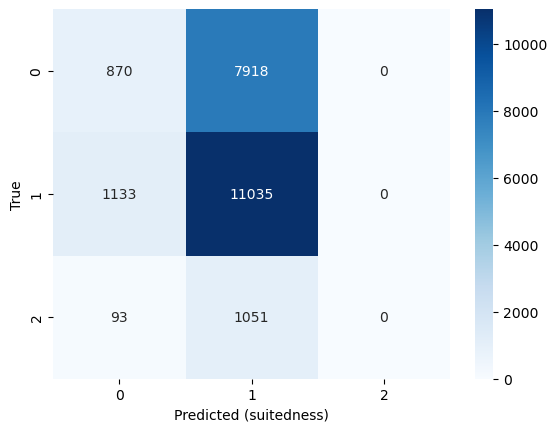

In [174]:
plot_confusion_matrix(model, dataloader, 'high_low_texture')
plot_confusion_matrix(model, dataloader, 'high_card')
plot_confusion_matrix(model, dataloader, 'connectedness')
plot_confusion_matrix(model, dataloader, 'pairness')
plot_confusion_matrix(model, dataloader, 'suitedness')

In [170]:
data.label_dict['suitedness']

{'idx': 0, 0: 'rainbow', 1: 'two_tone', 2: 'monotone'}